In [165]:
%load_ext autoreload
%autoreload 
%aimport CustomFunctions
cufu = CustomFunctions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from datetime import datetime as dt 
from datetime import timedelta

#Load information about different gas stations and price development from csv files
stations = pd.read_csv("example_sprit_cut_station.csv", delimiter=";")
prices = pd.read_csv("example_sprit_cut_prices.csv", delimiter=";")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# Get first date of every station
id_groups_min_date = prices.groupby("STID")["DATE_CHANGED"].min()

# Get date of first observed value of all stations (longest time history)
min_date_string = id_groups_min_date.sort_values().head(1).values[0]

# Get first full day (7 to 20) after first day measured
min_date = (cufu.time_stamp_to_date(min_date_string) + timedelta(days=1)).replace(minute=00, hour=7, second=00)
print("min_date: " + str(min_date))

# Get all ids that were already measurd on the first full day
ids_longest_time_hist = prices.loc[prices["DATE_CHANGED"].apply(cufu.time_stamp_to_date) <= min_date]["STID"].values


min_date: 2014-06-09 07:00:00


In [167]:
# Only consider values between 7 and 20 o'clock
prices_7_20 = prices.loc[prices["STID"].isin(ids_longest_time_hist)]
prices_7_20 = prices_7_20.loc[prices_7_20["DATE_CHANGED"].apply(cufu.between_7_20)]



In [168]:
# Get 100 IDs with most values in this time frame
ids_most_values = prices_7_20.groupby("STID").size().sort_values().tail(100).index.values

# Get all prices corresponding to those ids
prices_most_values = prices_7_20.loc[prices_7_20["STID"].isin(ids_most_values)]

# Convert time stamp to day only
prices_most_values["DATE_CHANGED"] = prices_most_values["DATE_CHANGED"].apply(cufu.time_stamp_to_day)

# Get time sorted ID groups
id_grouped = prices_most_values.sort_values(by="DATE_CHANGED").groupby("STID")

# Find earliest and latest date that was measured
earliest_date = None
latest_date = None
for key, item in id_grouped:
    id_group = id_grouped.get_group(key)
    group_min_date = id_group.head(1)["DATE_CHANGED"].values[0]
    group_max_date = id_group.tail(1)["DATE_CHANGED"].values[0]
    
    if earliest_date == None or group_min_date < earliest_date:
        earliest_date = group_min_date

    if latest_date == None or group_max_date > latest_date:
        latest_date = group_max_date    

# Add one day to date to get first day fully measured
earliest_date = dt.strptime(earliest_date, "%Y-%m-%d") + timedelta(days=1)
latest_date = dt.strptime(latest_date, "%Y-%m-%d") - timedelta(days=1)

print("earliest_date: " + str(earliest_date))
print("max date: " + str(latest_date))

# Count days to construct list of dates between earliest and latest date
days_passed = (latest_date - earliest_date).days + 1
date_list = [str((min_date + timedelta(days=1*x)).date()) for x in range(0, days_passed)]

# Create dataframes for average prices were columns are dates and rows are different stations
df_e5 = pd.DataFrame(columns=date_list)
df_e10 = pd.DataFrame(columns=date_list)
df_diesel = pd.DataFrame(columns=date_list)

df_e5.insert(loc=0, column='ID', value=id_grouped.groups.keys())
df_e10.insert(loc=0, column='ID', value=id_grouped.groups.keys())
df_diesel.insert(loc=0, column='ID', value=id_grouped.groups.keys())



earliest_date: 2014-06-09 00:00:00
max date: 2015-09-28 00:00:00


In [169]:

# Fill dataframes with price values
for key, item in id_grouped:
    id_group = id_grouped.get_group(key)
    
    ids_correct_date = id_group["DATE_CHANGED"].isin(date_list)
    id_groupe_correct_date = id_group.loc[ids_correct_date]
    
    # Get daily mean prices
    mean_prices = id_groupe_correct_date.groupby("DATE_CHANGED")[["E5", "E10", "DIESEL"]].mean()
    
    # Get datees of mean prices
    prices_dates = mean_prices.index 
    
    # Get boolean index of those dates that were measured for the current id
    e5_colmuns_indexes = df_e5.loc[df_e5['ID'] == key].columns.isin(prices_dates)
    # Set e5 prices of current id for the days measured
    df_e5.loc[df_e5['ID'] == key, e5_colmuns_indexes] = mean_prices["E5"].values     

    # Get boolean index of those dates that were measured for the current id
    e10_colmuns_indexes = df_e10.loc[df_e10['ID'] == key].columns.isin(prices_dates)
    # Set e5 prices of current id for the days measured    
    df_e10.loc[df_e10['ID'] == key, e10_colmuns_indexes] = mean_prices["E10"].values 

    # Get boolean index of those dates that were measured for the current id    
    diesel_colmuns_indexes = df_diesel.loc[df_diesel['ID'] == key].columns.isin(prices_dates)
    # Set e5 prices of current id for the days measured    
    df_diesel.loc[df_diesel['ID'] == key, diesel_colmuns_indexes] = mean_prices["DIESEL"].values 

    


In [170]:
def check_if_in_range(value, lower_bound, upper_bound):
    if isinstance(value, str) or ((value > lower_bound) and (value < upper_bound)):
        return value
    return float('NaN')

# Check if value is unrealistically small or big and replace with NaN
df_e5 = df_e5.applymap(lambda x: check_if_in_range(x, 500, 2000))
df_e10 = df_e10.applymap(lambda x: check_if_in_range(x, 500, 2000))
df_diesl = df_diesel.applymap(lambda x: check_if_in_range(x, 500, 2000))

# Fill missing values with value of next row
df_e5 = df_e5.fillna(method = "bfill")
df_e10 = df_e10.fillna(method = "bfill")
df_diesel = df_diesel.fillna(method = "bfill")



In [213]:

# Apply simple moving window model
from sklearn.model_selection import TimeSeriesSplit
cufu.suspress_ARIMA_warnigs()

# Test for three stations first
e5_3_stations = df_e5.drop('ID', axis=1).head(3)/1000
e10_3_stations = df_e10.drop('ID', axis=1).head(3)/1000
diesel_3_stations = df_diesel.drop('ID', axis=1).head(3)/1000

# Number of training samples taken into account for prediction
max_train_data_size = 20
# Number of days to predict
max_test_data_size = 1

number_splits = 5
tscv = TimeSeriesSplit(max_train_size=max_train_data_size, n_splits=number_splits)

# Lists for mean absolute deviation
mad_list_e5_ma = []
mad_list_e10_ma = []
mad_list_diesel_ma = []

# Lists of mean absolute percentage error
mape_list_e5_ma = []
mape_list_e10_ma = []
mape_list_diesel_ma = []


In [214]:
# One step of progress bar
step_size = 1./float(number_splits*(e5_3_stations.shape[0] + e10_3_stations.shape[0] + diesel_3_stations.shape[0]))
progress_percent = 0
cufu.update_progress(progress_percent) 

for train_index, test_index in tscv.split(e5_3_stations.loc[0]):
    
    # Loop through three stations
    for index, station_e5 in e5_3_stations.iterrows():
        # Get train and test data
        e5_train = station_e5[train_index]
        e5_test = station_e5[test_index][:max_test_data_size]
        e5_pred = cufu.apply_moving_average(e5_train, e5_test)
        
        mad_list_e5_ma.append(cufu.get_mad(e5_test.values, e5_pred))
        mape_list_e5_ma.append(cufu.get_mape(e5_test.values, e5_pred))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 
    
    # Loop through three stations    
    for index, station_e10 in e10_3_stations.iterrows():
        # Get train and test data
        e10_train = station_e10[train_index]
        e10_test = station_e10[test_index][:max_test_data_size]
        e10_pred = cufu.apply_moving_average(e10_train, e10_test)
        
        mad_list_e10_ma.append(cufu.get_mad(e10_test.values, e10_pred))
        mape_list_e10_ma.append(cufu.get_mape(e10_test.values, e10_pred))
        
        progress_percent += step_size
        cufu.update_progress(progress_percent) 
    
    # Loop through three stations
    for index, station_diesel in diesel_3_stations.iterrows():
        # Get train and test data
        diesel_train = station_diesel[train_index]
        diesel_test = station_diesel[test_index][:max_test_data_size]
        diesel_pred = cufu.apply_moving_average(diesel_train, diesel_test)
        
        mad_list_diesel_ma.append(cufu.get_mad(diesel_test.values, diesel_pred))
        mape_list_diesel_ma.append(cufu.get_mape(diesel_test.values, diesel_pred))
    
        progress_percent += step_size
        cufu.update_progress(progress_percent) 

cufu.update_progress(1.0)

Progress: [####################] 100.0%


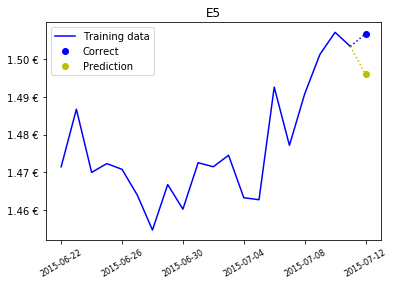

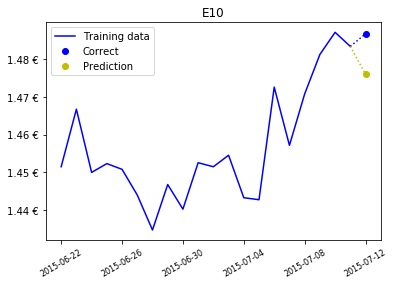

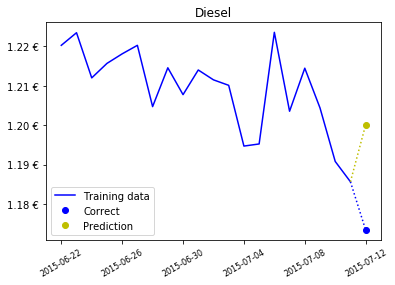

In [215]:
        
# Plot Example Predictions 
cufu.plot_time_series_pred(e5_train, e5_test, e5_pred, "E5")
cufu.plot_time_series_pred(e10_train, e10_test, e10_pred, "E10")
cufu.plot_time_series_pred(diesel_train, diesel_test, diesel_pred, "Diesel")


In [216]:
# get average mean absolute deviation
average_mad_e5_ma = sum(mad_list_e5_ma)/len(mad_list_e5_ma)
average_mad_e10_ma = sum(mad_list_e10_ma)/len(mad_list_e10_ma)
average_mad_diesel_ma = sum(mad_list_diesel_ma)/len(mad_list_diesel_ma)

# get average mean absolute percentage error
average_mape_e5_ma = sum(mape_list_e5_ma)/len(mape_list_e5_ma)
average_mape_e10_ma = sum(mape_list_e10_ma)/len(mape_list_e10_ma)
average_mape_diesel_ma = sum(mape_list_diesel_ma)/len(mape_list_diesel_ma)

print("E5 average mad error: %1.4f €"  % average_mad_e5_ma)
print("E10 average mad error: %1.4f €" % average_mad_e10_ma)
print("Diesel average mad error: %1.4f €" % average_mad_diesel_ma)
print("\n")
print("E5 average mape error: %3.2f %%"  % average_mape_e5_ma)
print("E10 average mape error: %3.2f %%" % average_mape_e10_ma)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel_ma)



E5 average mad error: 0.0163 €
E10 average mad error: 0.0157 €
Diesel average mad error: 0.0144 €


E5 average mape error: 1.12 %
E10 average mape error: 1.10 %
Diesel average mape error: 1.18 %


In [205]:
e5 = pd.DataFrame(e5_3_stations).reset_index()
e10 = pd.DataFrame(e10_3_stations).reset_index()
diesel = pd.DataFrame(diesel_3_stations).reset_index()

# Number of training samples taken into account for prediction
max_train_data_size = 20
# Number of samples to predict
max_test_data_size = 1

tscv = TimeSeriesSplit(max_train_size=max_train_data_size, n_splits=5)

# Lists for mean absolute deviation
mad_list_e5_prophet = []
mad_list_e10_prophet = []
mad_list_diesel_prophet = []

# Lists of mean absolute percentage error
mape_list_e5_prophet = []
mape_list_e10_prophet = []
mape_list_diesel_prophet = []

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


Progress: [####################] 100.0%


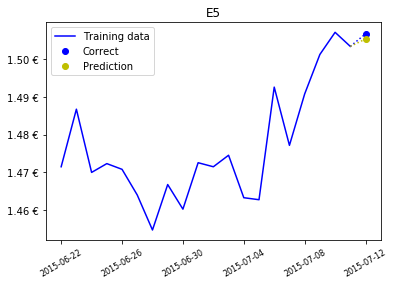

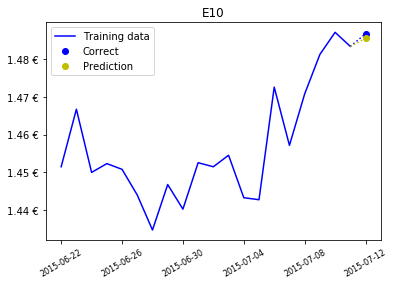

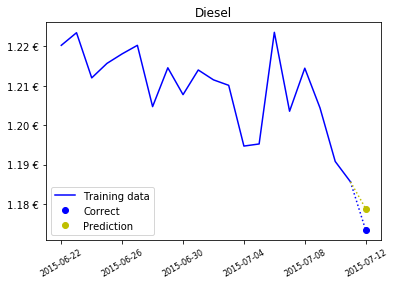

In [206]:
progress_percent = 0
cufu.update_progress(progress_percent) 

for train_index, test_index in tscv.split(e5_3_stations.loc[0]):  
   
    # Loop through three stations
    for index, station_e5 in e5_3_stations.iterrows():
        df_station_e5 = pd.DataFrame(np.array([station_e5.index.values, station_e5.values]).T, columns=['ds', 'y'])
        e5_train = df_station_e5.iloc[train_index]
        e5_test = df_station_e5.iloc[test_index].head(max_test_data_size)
        
        e5_pred = cufu.apply_fb_prophet(e5_train, max_test_data_size)
        
        mad_list_e5_prophet.append(cufu.get_mad(e5_test["y"].values, e5_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_e5_prophet.append(cufu.get_mape(e5_test["y"].values, e5_pred.tail(max_test_data_size)["yhat"].values))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 
    
    # Loop through three stations
    for index, station_e10 in e10_3_stations.iterrows():
        df_station_e10 = pd.DataFrame(np.array([station_e10.index.values, station_e10.values]).T, columns=['ds', 'y'])
        e10_train = df_station_e10.iloc[train_index]
        e10_test = df_station_e10.iloc[test_index].head(max_test_data_size)
        e10_pred = cufu.apply_fb_prophet(e10_train, max_test_data_size)
  
        mad_list_e10_prophet.append(cufu.get_mad(e10_test["y"].values, e10_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_e10_prophet.append(cufu.get_mape(e10_test["y"].values, e10_pred.tail(max_test_data_size)["yhat"].values))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 
    
    # Loop through three stations    
    for index, station_diesel in diesel_3_stations.iterrows():
        df_station_diesel = pd.DataFrame(np.array([station_diesel.index.values, station_diesel.values]).T, columns=['ds', 'y'])
        diesel_train = df_station_diesel.iloc[train_index]
        diesel_test = df_station_diesel.iloc[test_index].head(max_test_data_size)
        diesel_pred = cufu.apply_fb_prophet(diesel_train, max_test_data_size)
        
        mad_list_diesel_prophet.append(cufu.get_mad(diesel_test["y"].values, diesel_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_diesel_prophet.append(cufu.get_mape(diesel_test["y"].values, diesel_pred.tail(max_test_data_size)["yhat"].values))
    
        progress_percent += step_size
        cufu.update_progress(progress_percent) 
        
# Plot Example Predictions 
cufu.plot_time_series_pred_prophet(e5_train, e5_test, e5_pred, "E5")
cufu.plot_time_series_pred_prophet(e10_train, e10_test, e10_pred, "E10")
cufu.plot_time_series_pred_prophet(diesel_train, diesel_test, diesel_pred, "Diesel")    


In [207]:

# get average mean absolute deviation
average_mad_e5_prophet = sum(mad_list_e5_prophet)/len(mad_list_e5_prophet)
average_mad_e10_prophet = sum(mad_list_e10_prophet)/len(mad_list_e10_prophet)
average_mad_diesel_prophet = sum(mad_list_diesel_prophet)/len(mad_list_diesel_prophet)

# get average mean absolute percentage error
average_mape_e5_prophet = sum(mape_list_e5_prophet)/len(mape_list_e5_prophet)
average_mape_e10_prophet = sum(mape_list_e10_prophet)/len(mape_list_e10_prophet)
average_mape_diesel_prophet = sum(mape_list_diesel_prophet)/len(mape_list_diesel_prophet)

print("E5 average mad error: %1.4f €"  % average_mad_e5_prophet)
print("E10 average mad error: %1.4f €" % average_mad_e10_prophet)
print("Diesel average mad error: %1.4f €" % average_mad_diesel_prophet)
print("\n")
print("E5 average mape error: %3.2f %%"  % average_mape_e5_prophet)
print("E10 average mape error: %3.2f %%" % average_mape_e10_prophet)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel_prophet)



E5 average mad error: 0.0156 €
E10 average mad error: 0.0145 €
Diesel average mad error: 0.0132 €


E5 average mape error: 1.08 %
E10 average mape error: 1.02 %
Diesel average mape error: 1.08 %


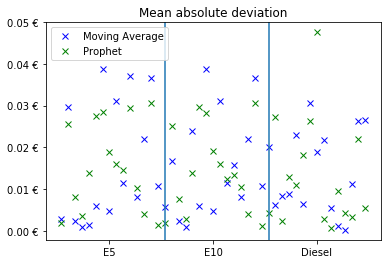

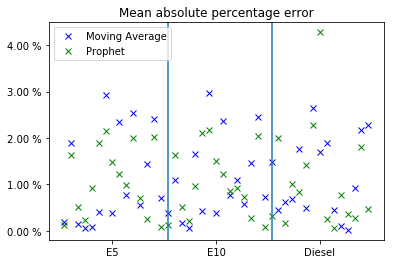

In [223]:
# Visualize results of prophet and moving average model
num_points = len(mape_list_e5_prophet + mape_list_e10_prophet + mape_list_diesel_prophet)

# Plot all mean absolute deviation points
plt.plot(mad_list_e5_ma + mad_list_e10_ma + mad_list_diesel_ma, 'bx', label="Moving Average")
plt.plot(mad_list_e5_prophet + mad_list_e10_prophet + mad_list_diesel_prophet, 'gx', label="Prophet")
plt.xticks([int(num_points/6), int(num_points/2), int(5*num_points/6)], ["E5", "E10", "Diesel"])
plt.axvline(num_points/3)
plt.axvline(2*num_points/3)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
plt.title("Mean absolute deviation")
plt.legend()
plt.show()

# Plot all mean absolute percentage error points
plt.plot(mape_list_e5_ma + mape_list_e10_ma + mape_list_diesel_ma, 'bx', label="Moving Average")
plt.plot(mape_list_e5_prophet + mape_list_e10_prophet + mape_list_diesel_prophet, 'gx', label="Prophet")
plt.xticks([int(num_points/6), int(num_points/2), int(5*num_points/6)], ["E5", "E10", "Diesel"])
plt.axvline(num_points/3)
plt.axvline(2*num_points/3)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f %%'))
plt.title("Mean absolute percentage error")
plt.legend()
plt.show()



In [178]:
# Compare both methods on full data set (100 stations)

# Get all 100 stations
e5_100_stations = df_e5.drop('ID', axis=1).head(100)/1000
e10_100_stations = df_e10.drop('ID', axis=1).head(100)/1000
diesel_100_stations = df_diesel.drop('ID', axis=1).head(100)/1000

# Number of training samples taken into account for prediction
max_train_data_size = 20
# Number of days to predict
max_test_data_size = 1

number_splits = 5
tscv = TimeSeriesSplit(max_train_size=max_train_data_size, n_splits=number_splits)

# Lists for mean absolute deviation
mad_list_e5 = []
mad_list_e10 = []
mad_list_diesel = []

# Lists of mean absolute percentage error
mape_list_e5 = []
mape_list_e10 = []
mape_list_diesel = []


In [194]:
# One step of progress bar
step_size = 1./float(number_splits*(e5_100_stations.shape[0] + e10_100_stations.shape[0] + diesel_100_stations.shape[0]))
progress_percent = 0
cufu.update_progress(progress_percent) 

for train_index, test_index in tscv.split(e5_100_stations.loc[0]):
    # Loop through 100 stations    
    for index, station_e5 in e5_100_stations.iterrows():
        # get train and test data
        e5_train = station_e5[train_index]
        e5_test = station_e5[test_index][:max_test_data_size]
        e5_pred = cufu.apply_moving_average(e5_train, e5_test)
        
        mad_list_e5.append(cufu.get_mad(e5_test.values, e5_pred))
        mape_list_e5.append(cufu.get_mape(e5_test.values, e5_pred))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 
        
    # Loop through 100 stations            
    for index, station_e10 in e10_100_stations.iterrows():
        # get train and test data
        e10_train = station_e10[train_index]
        e10_test = station_e10[test_index][:max_test_data_size]
        e10_pred = cufu.apply_moving_average(e10_train, e10_test)
        
        mad_list_e10.append(cufu.get_mad(e10_test.values, e10_pred))
        mape_list_e10.append(cufu.get_mape(e10_test.values, e10_pred))
        
        progress_percent += step_size
        cufu.update_progress(progress_percent) 
    
    # Loop through 100 stations    
    for index, station_diesel in diesel_100_stations.iterrows():
        # get train and test data
        diesel_train = station_diesel[train_index]
        diesel_test = station_diesel[test_index][:max_test_data_size]
        diesel_pred = cufu.apply_moving_average(diesel_train, diesel_test)
        
        mad_list_diesel.append(cufu.get_mad(diesel_test.values, diesel_pred))
        mape_list_diesel.append(cufu.get_mape(diesel_test.values, diesel_pred))
    
        progress_percent += step_size
        cufu.update_progress(progress_percent) 

cufu.update_progress(1.0)

Progress: [####################] 100.0%


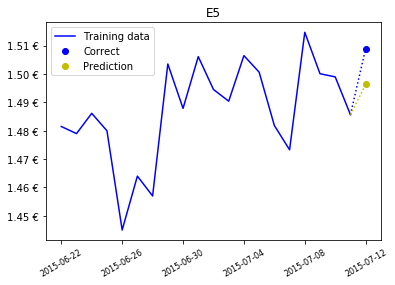

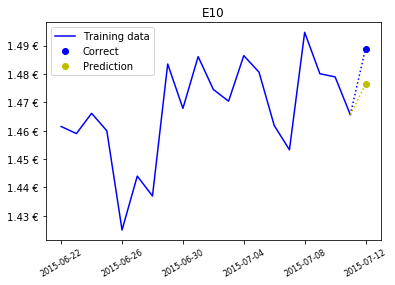

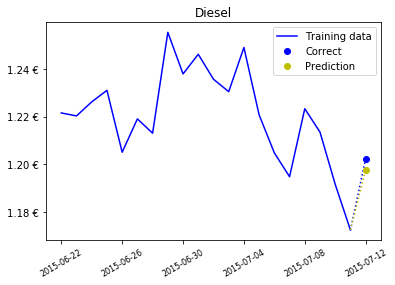

In [195]:
        
# Plot Example Predictions 
cufu.plot_time_series_pred(e5_train, e5_test, e5_pred, "E5")
cufu.plot_time_series_pred(e10_train, e10_test, e10_pred, "E10")
cufu.plot_time_series_pred(diesel_train, diesel_test, diesel_pred, "Diesel")



In [196]:

# get average mean absolute deviation
average_mad_e5 = sum(mad_list_e5)/len(mad_list_e5)
average_mad_e10 = sum(mad_list_e10)/len(mad_list_e10)
average_mad_diesel = sum(mad_list_diesel)/len(mad_list_diesel)

# get average mean absolute percentage error
average_mape_e5 = sum(mape_list_e5)/len(mape_list_e5)
average_mape_e10 = sum(mape_list_e10)/len(mape_list_e10)
average_mape_diesel = sum(mape_list_diesel)/len(mape_list_diesel)

print("E5 average mad error: %1.4f €"  % average_mad_e5)
print("E10 average mad error: %1.4f €" % average_mad_e10)
print("Diesel average mad error: %1.4f €" % average_mad_diesel)
print("\n")
print("E5 average mape error: %3.2f %%"  % average_mape_e5)
print("E10 average mape error: %3.2f %%" % average_mape_e10)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel)



E5 average mad error: 0.0180 €
E10 average mad error: 0.0172 €
Diesel average mad error: 0.0184 €


E5 average mape error: 1.25 %
E10 average mape error: 1.21 %
Diesel average mape error: 1.48 %


In [197]:

# Number of training samples taken into account for prediction
max_train_data_size = 20
# Number of samples to predict
max_test_data_size = 1

tscv = TimeSeriesSplit(max_train_size=max_train_data_size, n_splits=5)

# Lists for mean absolute deviation
mad_list_e5 = []
mad_list_e10 = []
mad_list_diesel = []

# Lists of mean absolute percentage error
mape_list_e5 = []
mape_list_e10 = []
mape_list_diesel = []

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)



Progress: [####################] 100.0%


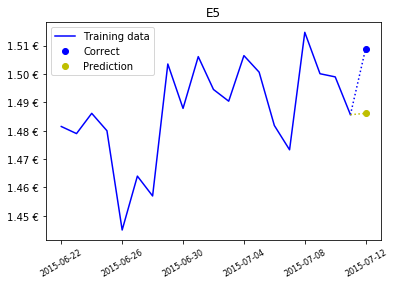

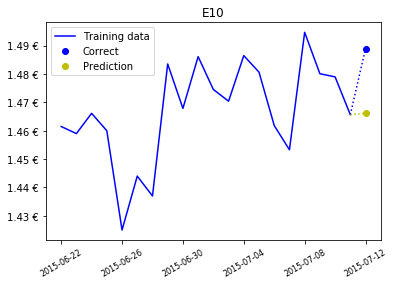

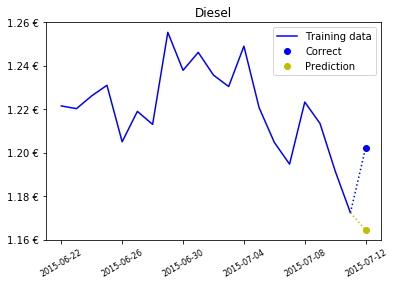

In [198]:
step_size = 1./float(number_splits*(e5_100_stations.shape[0] + e10_100_stations.shape[0] + diesel_100_stations.shape[0]))
progress_percent = 0
cufu.update_progress(progress_percent) 

for train_index, test_index in tscv.split(e5_100_stations.loc[0]):  
    # Loop through 100 stations    
    for index, station_e5 in e5_100_stations.iterrows():
        df_station_e5 = pd.DataFrame(np.array([station_e5.index.values, station_e5.values]).T, columns=['ds', 'y'])
        e5_train = df_station_e5.iloc[train_index]
        e5_test = df_station_e5.iloc[test_index].head(max_test_data_size)
        
        e5_pred = cufu.apply_fb_prophet(e5_train, max_test_data_size)
        
        mad_list_e5.append(cufu.get_mad(e5_test["y"].values, e5_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_e5.append(cufu.get_mape(e5_test["y"].values, e5_pred.tail(max_test_data_size)["yhat"].values))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 

    # Loop through 100 stations    
    for index, station_e10 in e10_100_stations.iterrows():
        df_station_e10 = pd.DataFrame(np.array([station_e10.index.values, station_e10.values]).T, columns=['ds', 'y'])
        e10_train = df_station_e10.iloc[train_index]
        e10_test = df_station_e10.iloc[test_index].head(max_test_data_size)
        e10_pred = cufu.apply_fb_prophet(e10_train, max_test_data_size)
  
        mad_list_e10.append(cufu.get_mad(e10_test["y"].values, e10_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_e10.append(cufu.get_mape(e10_test["y"].values, e10_pred.tail(max_test_data_size)["yhat"].values))

        progress_percent += step_size
        cufu.update_progress(progress_percent) 

    # Loop through 100 stations            
    for index, station_diesel in diesel_100_stations.iterrows():
        df_station_diesel = pd.DataFrame(np.array([station_diesel.index.values, station_diesel.values]).T, columns=['ds', 'y'])
        diesel_train = df_station_diesel.iloc[train_index]
        diesel_test = df_station_diesel.iloc[test_index].head(max_test_data_size)
        diesel_pred = cufu.apply_fb_prophet(diesel_train, max_test_data_size)
        
        mad_list_diesel.append(cufu.get_mad(diesel_test["y"].values, diesel_pred.tail(max_test_data_size)["yhat"].values))
        mape_list_diesel.append(cufu.get_mape(diesel_test["y"].values, diesel_pred.tail(max_test_data_size)["yhat"].values))
    
        progress_percent += step_size
        cufu.update_progress(progress_percent) 

    
# Plot Example Predictions 
cufu.plot_time_series_pred_prophet(e5_train, e5_test, e5_pred, "E5")
cufu.plot_time_series_pred_prophet(e10_train, e10_test, e10_pred, "E10")
cufu.plot_time_series_pred_prophet(diesel_train, diesel_test, diesel_pred, "Diesel")    


In [199]:

# get average mean absolute deviation
average_mad_e5 = sum(mad_list_e5)/len(mad_list_e5)
average_mad_e10 = sum(mad_list_e10)/len(mad_list_e10)
average_mad_diesel = sum(mad_list_diesel)/len(mad_list_diesel)

# get average mean absolute percentage error
average_mape_e5 = sum(mape_list_e5)/len(mape_list_e5)
average_mape_e10 = sum(mape_list_e10)/len(mape_list_e10)
average_mape_diesel = sum(mape_list_diesel)/len(mape_list_diesel)

print("E5 average mad error: %1.4f €"  % average_mad_e5)
print("E10 average mad error: %1.4f €" % average_mad_e10)
print("Diesel average mad error: %1.4f €" % average_mad_diesel)
print("\n")
print("E5 average mape error: %3.2f %%"  % average_mape_e5)
print("E10 average mape error: %3.2f %%" % average_mape_e10)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel)


E5 average mad error: 0.0164 €
E10 average mad error: 0.0163 €
Diesel average mad error: 0.0155 €


E5 average mape error: 1.13 %
E10 average mape error: 1.14 %
Diesel average mape error: 1.24 %
